# 20/05/17

Looked up papers on using using tied states vs phoneme states. (review here https://docs.google.com/document/d/17VhroitGucKZoqIEYZLYoK8y62Kw2L-h0o2uCZpG9gc/edit?usp=sharing)

Dahl, George E., et al. "Context-dependent pre-trained deep neural networks for large-vocabulary speech recognition." IEEE Transactions on Audio, Speech, and Language Processing 20.1 (2012): 30-42. used tied states

# 27/05/17

In [ ]:
#feature extraction code
from python_speech_features import fbank
import numpy as np
from scipy.io import wavfile
from scipy.signal import hamming
import os
root = '/home/mshah1/wsj/wsj0/'
fileList = root + 'wsj0.wavlist'
with open(fileList,'r') as f:
	files = f.readlines()
	files = map(lambda x: x.strip(), files)

for f in files:
	if not os.path.exists(root + f + '.mls'):
		print f
		(rate,data) = wavfile.read(root + f)
		(feat,_) = fbank(data,samplerate=rate,winlen=0.025,
							winstep=0.015,nfilt=40,nfft=1024,
							lowfreq=250,winfunc=hamming)
		feat = np.log(feat)
		np.savetxt(root + f + '.mls',feat)

In [ ]:
#random label assignment code
def fileToLabels(data, nPhones=30):	
	nFrames = data.shape[0]
	nPhones = nPhones + np.random.randint(-5,high=5)
	segLen = nFrames / nPhones
	labels = []
	for i in range(nPhones):
		currSegLen = segLen + np.random.randint(-10,high=10)
		labels += [np.random.randint(0,high=3000)]*min(currSegLen,nFrames - len(labels))
	return labels

In [ ]:
#MLP1:
#classification accuracy an abysmal 0.00033
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.models import load_model
import numpy as np

data = np.load('wsj0_randlabels.npz')
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_dim=40))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(3000, activation='softmax'))
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
x_train = data['X_Train'][:1000000]
y_train = data['Y_Train'][:1000000]
y_train = to_categorical(y_train, num_classes = 3000)
model.fit(x_train,y_train,epochs=10,batch_size=20000)
model.save("mlp_randomAlign.h5")

Changed winstep to 0.01, accuracy went up to 0.00054

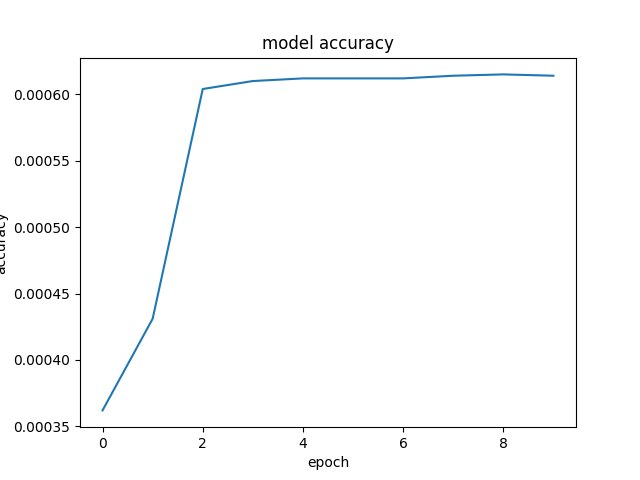

Changed optimizer to rmsprop accuracy went down to 0.00031

accuracy with 250000 testing samples with adagrad = 0.00035

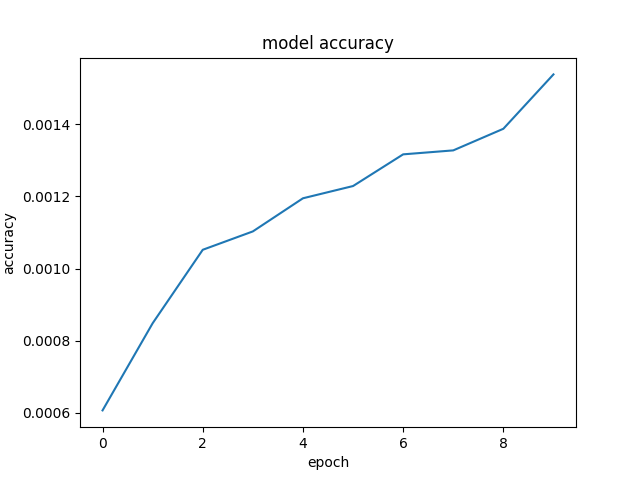

accuracy with relu activations = 0.00031 (training accuracy went up significantly to 0.014)

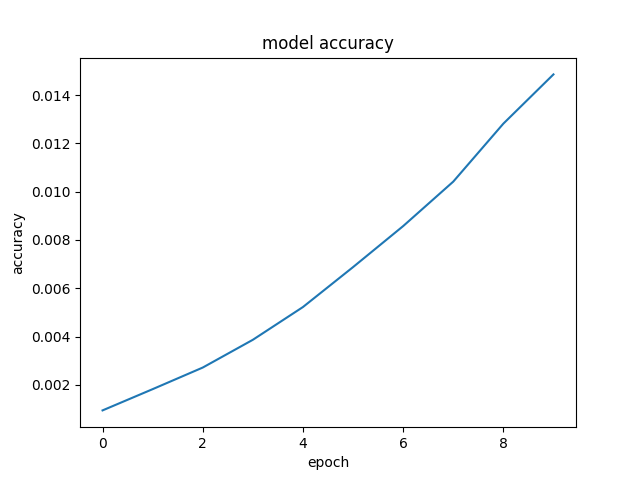

In [ ]:
# MLP3: Deeper MLP model  
# accuracy is 0.00032
def mlp3():
	model = Sequential()
	model.add(Dense(500, activation='relu', input_dim=40))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(500, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(3000, activation='softmax'))
	model.compile(optimizer='adagrad',
	              loss='categorical_crossentropy',
	              metrics=['accuracy'])
	return model

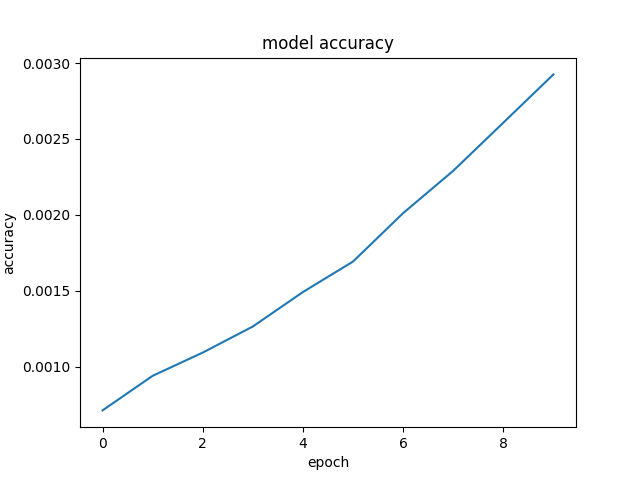

# 28/5/17

Tried using sphinx3_align,, threw the following error
ERROR: "main_align.c", line 974: Uttid mismatch: ctlfile =
  "02aa010i.wv2.flac"; transcript =
  "11_10_1/wsj0/sd_tr_s/00f/00fc031m.wv2"
 
  INFO: feat.c(1205): At directory feat/
 
  INFO: feat.c(1022): Reading mfc file:
  'feat//./11_8_1/wsj0/si_tr_s/02a/02aa010i.wv2.flac.mfc'[0..-1]
 
  INFO: cmn.c(175): CMN: 49.71 -5.35 -6.24  8.33  5.61  7.87 -3.84
  -1.53
  -6.34
  -13.66 -11.63 -8.54 -13.30
 
  INFO: main_align.c(1009): 02aa010i.wv2.flac: 465 input frames
 
 
 
  ERROR: "main_align.c", line 891: Final state not reached; no
  alignment
  for
  02aa010i.wv2.flac


# 30/5/17

Setup sphinx3 on genie

# 1/6/17

Refactored the transcripts and the ctlist so that filenames match
Error persists

# 5/6/17

In [ ]:
# re-ran feature extraction using sphinx_fe
sphinx_fe -argfile ~/wsj_all_cd30.mllt_cd_cont_4000/feat.params -c etc/wsj0_train.fileids -di wav/ -do feat/ -mswav yes -eo mfc -ei wav

In [ ]:
# Re-ran alignment and obtained state-level segmentations
sphinx3_align -hmm ~/wsj_all_cd30.mllt_cd_cont_4000/ -dict transcripts/wsj0/cmudict.0.6d.wsj0 -ctl etc/wsj0_train.fileids -cepdir feat/ -cepext .mfc -insent transcripts/wsj0/wsj0.trans2 -outsent wsj0.out -lda ~/wsj_all_cd30.mllt_cd_cont_4000/feature_transform -cmn batch -stsegdir statesegdir

# 6/6/17

In [ ]:
# code for reading .stseg files and saving them as ASCII (slightly modified from the version found 
# online since the types didn't match)

/* ====================================================================
 * Copyright (c) 1995-2002 Carnegie Mellon University.  All rights
 * reserved.
 *
 * Redistribution and use in source and binary forms, with or without
 * modification, are permitted provided that the following conditions
 * are met:
 *
 * 1. Redistributions of source code must retain the above copyright
 *    notice, this list of conditions and the following disclaimer.
 *
 * 2. Redistributions in binary form must reproduce the above copyright
 *    notice, this list of conditions and the following disclaimer in
 *    the documentation and/or other materials provided with the
 *    distribution.
 *
 * This work was supported in part by funding from the Defense Advanced
 * Research Projects Agency and the National Science Foundation of the
 * United States of America, and the CMU Sphinx Speech Consortium.
 *
 * THIS SOFTWARE IS PROVIDED BY CARNEGIE MELLON UNIVERSITY ``AS IS'' AND
 * ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
 * THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
 * PURPOSE ARE DISCLAIMED.  IN NO EVENT SHALL CARNEGIE MELLON UNIVERSITY
 * NOR ITS EMPLOYEES BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
 * SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
 * LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
 * DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
 * THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
 * (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
 * OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
 *
 * ====================================================================
 *
 */
/*
 * stseg.c -- Read and display .stseg file created by s3align.
 *
 * **********************************************
 * CMU ARPA Speech Project
 *
 * Copyright (c) 1996 Carnegie Mellon University.
 * ALL RIGHTS RESERVED.
 * **********************************************
 *
 * HISTORY
 *
 * 19-Jul-96    M K Ravishankar (rkm@cs.cmu.edu) at Carnegie Mellon University
 *              Created.
 */


#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <assert.h>
#include <stdint.h>

/* "\nCI.8 LC.8 RC.8 POS.3(HI)-ST.5(LO) SCR(32)" */

static char *phone[100];
static int n_phone;
static char *posname = "besiu";


static skip_line (FILE *fp)
{
    int c;

    while (((c = fgetc (fp)) >= 0) && (c != '\n'));
}


main ()
{
    int i, k, nf, scr;
    int16_t c;
    FILE *fp;
    int16_t str[3];
    char str1[1024];
    fp = stdin;
    n_phone = 0;

    /* Skip version# string */
    skip_line (fp);

    /* Read CI phone names */
    for (;;) {
        for (i = 0;; i++) {
            if (((c = fgetc(fp)) == ' ') || (c == '\n'))
                break;
            str1[i] = c;
        }
        str1[i] = '\0';

        if (c == ' ') {
            phone[n_phone] = (char *) malloc (i+1);
            strcpy (phone[n_phone], str1);
            n_phone++;
        } else
            break;
    }
    printf ("%d phones\n", n_phone);

    /* Skip format line */
    skip_line (fp);

    /* Skip end-comment line */
    skip_line (fp);

    /* Read byteorder magic no. */
    fread (&i, sizeof(int), 1, fp);
    assert (i == 0x11223344);

    /* Read no. frames */
    fread (&nf, sizeof(int), 1, fp);
    printf ("#frames = %d\n", nf);

    char pos[1];
    /* Read state info per frame */
    for (i = 0; i < nf; i++) {
        k = fread (str, sizeof(uint16_t), 3, fp);
        str[3] = 0;
        assert (k == 3);
        k = fread (pos, sizeof(char), 1, fp);
        assert (k == 1);
        k = fread (&scr, sizeof(int), 1, fp);
        assert (k == 1);

        c = str[0];
        //printf("c=%d\n",c);
        assert ((c >= 0) && (c < n_phone));
        printf ("%5d %11d %2d %s", i, scr, pos[0] & 0x001f, phone[c]);

        c = str[1];
        //printf("c2=%d\n",c);
        if (c != -1) {
            assert ((c >= 0) && (c < n_phone));
            printf (" %s", phone[c]);
        }

        c = str[2];
        //printf("c3=%d\n",c);
        if (c != -1) {
            assert ((c >= 0) && (c < n_phone));
            printf (" %s", phone[c]);
        }

        c = (pos[0] >> 5) & 0x07;
        if ((c >= 0) && (c < 4))
            printf (" %c", posname[c]);

        printf ("\n");
    }
}


Example alignment output
44 phones
#frames = 349
    0      -32931  0 SIL
    1      -29131  1 SIL
    2      -21946  2 SIL
    3      -11502  2 SIL
    4        -661  2 SIL
    5       -8628  2 SIL
    6      -15577  2 SIL
    7       -9964  0 DH SIL AH e
    8       -9648  1 DH SIL AH e
    9       -5518  1 DH SIL AH e

# 7/6/17

In [ ]:
# Extract Mel-Log Likelihood Using sphinx_fe
sphinx_fe -argfile ~/wsj_all_cd30.mllt_cd_cont_4000/feat.params -c etc/wsj0_train.fileids -di feat/ -do feat_spec/ -eo mls -ei mfc -cep2spec yes -ofmt text

In [ ]:
# Mapped the alignments to phoneme states (not tied states, just the state corresponding to the base phone and the position)
# using the following script

def read_sen_labels_from_mdef(fname, onlyPhone=True):
#     create a phoneme-senoneID dictionary using a mdef file
#     inputs: mdef file
#     outputs: phoneme-senoneID dictionary
	labels = np.loadtxt(fname,dtype=str,skiprows=10,usecols=(0,6,7,8))
	if onlyPhone:
		labels = labels[:44]
	phone2state = {}
	for r in labels:
		phone2state[r[0]] = map(int, r[1:])
	return phone2state

def frame2state(fname, phone2state, onlyPhone=True):
#     determine the senoneID for a frame (a row in the alignment file)
#     inputs: alignment file (in ASCII), phoneme-senoneID dictionary
#     output: list of states indexed according to frame numbers
	with open(fname,'r') as f:
		lines = f.readlines()[2:]
	lines = map(lambda x: x.split()[2:], lines)
	if onlyPhone:
		lines = map(lambda x: x[:2],lines)
	else:
		lines = map(lambda x: [x[0], reduce(lambda a,b: a+' '+b,x[1:])],lines)
	states = map(lambda x: phone2state[x[1]][int(x[0])], lines)
	return (list(states))

def genDataset(DB_path, filelist, stseg_path, mdef_fname):
	files = np.loadtxt(DB_path+filelist,dtype=str)
	files = map(lambda x: DB_path+x,files)
	fileWOpath = map(lambda x: x.split('/')[-1][:-3]+'stseg.txt',files)
	stseg_files = filter(lambda x: os.path.exists(DB_path + stseg_path + x), fileWOpath)
	phone2state = read_sen_labels_from_mdef(mdef_fname)
	allData = []
	allLabels = []
	for f in (stseg_files):
		data_file = filter(lambda x: f[:-9] in x, files)[0]
		print data_file, f
		data = np.loadtxt(data_file)
		labels = frame2state(DB_path + stseg_path + f, phone2state)
		nFrames = min(len(labels), data.shape[0])
		data = data[:nFrames]
		labels = labels[:nFrames]
		assert(len(labels) == data.shape[0])
		allData += list(data)
		allLabels += list(labels)
		assert(len(allLabels) == len(allData))
	# print allData
	print len(allData), len(allLabels)
	lenTrain = len(allData) * 3 / 4
	X_Train = allData[:lenTrain]
	Y_Train = allLabels[:lenTrain]
	X_Test = allData[lenTrain:]
	Y_Test = allLabels[lenTrain:]
	np.savez('wsj0_phonelabels',X_Train=X_Train,Y_Train=Y_Train,X_Test=X_Test,Y_Test=Y_Test)

Running test with MLPs
Training set: 30,040,440 frames
Testing set: 10,013,481 frames

MLP3: testing accuracy = 20.8%
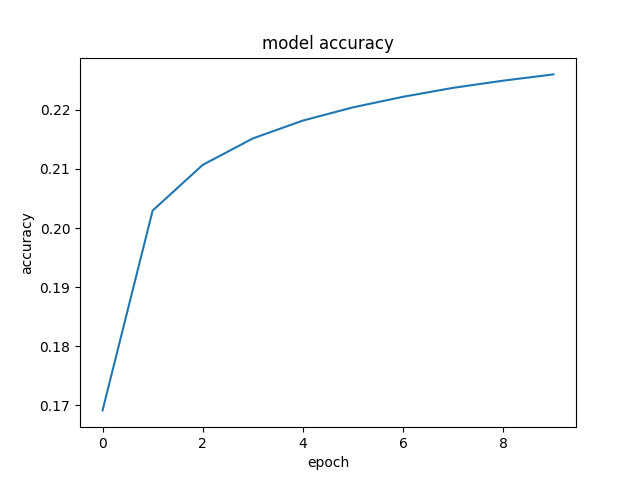

MLP1: testing accuracy = 19.4 %
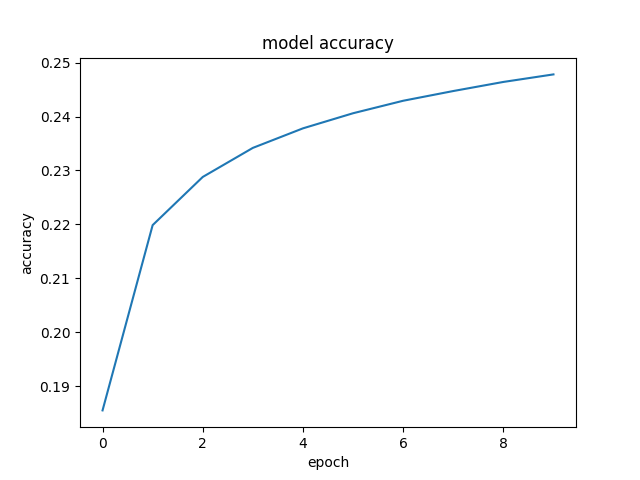

In [ ]:
# Basic resnet 
def make_dense_res_block(inp, size):
	x = inp
	for i in range(size):
		x = Dense(500, activation='relu')(x)
		x = Dropout(0.25)(x)
	return x

def mlp4(input_dim,output_dim,nBlocks):
	inp = Input(shape=(input_dim,))
	x = Dense(500, activation='relu')(inp)
	for i in range(nBlocks):
		y = make_res_block(x,2)
		x = add([x,y])
	z = Dense(output_dim, activation='softmax')(x)
	model = Model(inputs=inp, outputs=z)
	model.compile(optimizer='rmsprop',
	              loss='categorical_crossentropy',
	              metrics=['accuracy'])
	return model

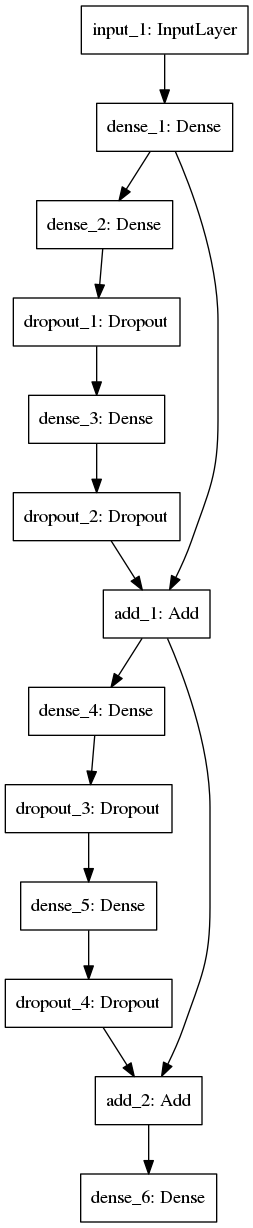

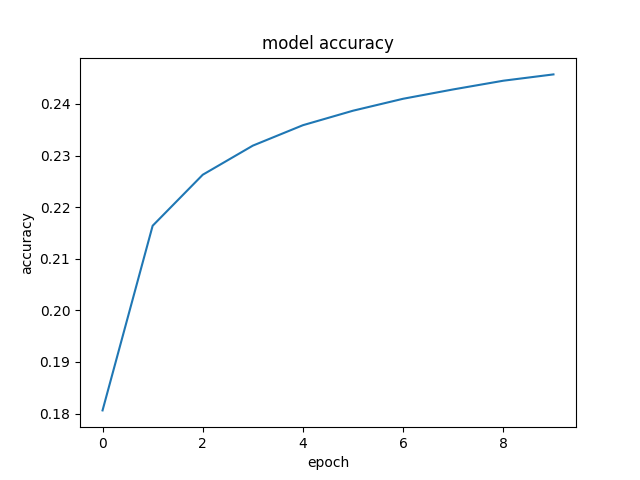

Testing accuracy: 19.25%

Making a deeper network with 10 residual blocks